# Modeling
We make forecasting models for our Power BI Report.

In [1]:
import pandas as pd

path = "../data/"
data = pd.read_csv(path+"processed/data.csv")
data.head()

,item_id,status,created_at,sku,price,qty_ordered,grand_total,increment_id,category_name_1,sales_commission_code,...,payment_method,Working Date,BI Status,MV,Year,Month,Customer Since,M-Y,FY,Customer ID
0,211133,canceled,2016-07-01,kccBuy2FreyAirFreshenerGet1KasualBodySprayFree,240.0,1.0,240.0,100147444,Beauty & Grooming,False,...,cod,2016-07-01,Gross,240.0,2016,7,2016-07-01,2016-07-01,FY17,2
1,211134,canceled,2016-07-01,EgoUP0017999MR0,2450.0,1.0,2450.0,100147445,Women's Fashion,False,...,cod,2016-07-01,Gross,2450.0,2016,7,2016-07-01,2016-07-01,FY17,3
2,211135,complete,2016-07-01,kcckronedeal,360.0,1.0,60.0,100147446,Beauty & Grooming,True,...,cod,2016-07-01,Net,360.0,2016,7,2016-07-01,2016-07-01,FY17,4
3,211136,refunded,2016-07-01,BK7010400AG,555.0,2.0,1110.0,100147447,Soghaat,False,...,cod,2016-07-01,Valid,1110.0,2016,7,2016-07-01,2016-07-01,FY17,5
4,211137,canceled,2016-07-01,UKNamkinoAllInOne200Gms,80.0,1.0,80.0,100147448,Soghaat,False,...,cod,2016-07-01,Gross,80.0,2016,7,2016-07-01,2016-07-01,FY17,6


# Data Preparation

## Time Series
Convert raw data to time series data.

Note, we consider each individual item as an order, so multiple items by same customer will be considered separate orders.

In [2]:
orders = data[["created_at", "item_id"]]
orders.columns = ["Date", "Total"]

orders = orders.groupby("Date")["Total"].count()

orders.head()

Date
2016-07-01    528
2016-07-02    254
2016-07-03    203
2016-07-04    216
2016-07-05    164
Name: Total, dtype: int64

In [3]:
revenue = data[["created_at", "grand_total"]]
revenue.columns = ["Date", "Total"]

revenue = revenue.groupby("Date")["Total"].sum()

revenue.head()

Date
2016-07-01    1284503.75
2016-07-02    1394837.48
2016-07-03    2143719.88
2016-07-04    1094068.25
2016-07-05     910507.50
Name: Total, dtype: float64

In [4]:
new_customers = data[["Customer Since", "Customer ID"]]
new_customers.columns = ["Date", "Total"]

print(data.shape[0])
print(len(data["Customer ID"].unique()))
print(new_customers.duplicated().sum())
print(len(data["Customer ID"].unique()) + new_customers.duplicated().sum())

print(new_customers.shape[0])
new_customers = new_customers.drop_duplicates()
print(new_customers.shape[0])

new_customers = new_customers.groupby("Date")["Total"].count()

new_customers.head()

576480
114211
462269
576480
576480
114211


Date
2016-07-01     2374
2016-08-01     3065
2016-09-01     4483
2016-10-01     2361
2016-11-01    14373
Name: Total, dtype: int64

Incomplete purchases comprise of all unfullfilled orders, e.g refunds, cancellation, payment failure etc.

In [5]:
incomplete_purchases = data[["created_at", "status"]]

print(incomplete_purchases.shape[0])
incomplete_purchases = incomplete_purchases[incomplete_purchases["status"] != "complete"]
incomplete_purchases = incomplete_purchases[incomplete_purchases["status"] != "received"]
incomplete_purchases = incomplete_purchases[incomplete_purchases["status"] != "payment_review"]
print(incomplete_purchases.shape[0])

incomplete_purchases.columns = ["Date", "Total"]
incomplete_purchases = incomplete_purchases.groupby("Date")["Total"].count()

incomplete_purchases.head()

576480
268815


Date
2016-07-01    167
2016-07-02    114
2016-07-03    113
2016-07-04     77
2016-07-05     69
Name: Total, dtype: int64

In [6]:
orders_by_cat = data[["created_at", "item_id", "category_name_1"]]
orders_by_cat.columns = ["Date", "Item ID", "Product Category"]

orders_by_cat = orders_by_cat.groupby(["Date", "Product Category"])["Item ID"].count()
orders_by_cat = pd.DataFrame(orders_by_cat).reset_index().pivot(columns=["Product Category"], index=["Date"])
orders_by_cat = orders_by_cat.fillna(0)

def col_name_correct(tup):
    return tup[1]
orders_by_cat.columns = orders_by_cat.columns.map(col_name_correct)

orders_by_cat.head()

,Appliances,Beauty & Grooming,Books,Computing,Entertainment,Health & Sports,Home & Living,Kids & Baby,Men's Fashion,Mobiles & Tablets,Others,School & Education,Soghaat,Superstore,Women's Fashion
Date,,,,,,,,,,,,,,,
2016-07-01,16.0,237.0,0.0,6.0,1.0,2.0,15.0,15.0,44.0,23.0,5.0,0.0,131.0,1.0,32.0
2016-07-02,14.0,43.0,1.0,12.0,2.0,4.0,13.0,9.0,42.0,25.0,1.0,0.0,80.0,0.0,8.0
2016-07-03,3.0,22.0,0.0,7.0,0.0,9.0,10.0,5.0,28.0,8.0,0.0,0.0,92.0,0.0,19.0
2016-07-04,9.0,38.0,0.0,8.0,2.0,3.0,10.0,7.0,40.0,15.0,3.0,7.0,65.0,0.0,9.0
2016-07-05,2.0,29.0,0.0,8.0,2.0,3.0,18.0,4.0,20.0,12.0,1.0,15.0,41.0,0.0,9.0


Note, we might have missing days. So lets correct that.

In [7]:
def get_days(series, date_col):
    df = pd.DataFrame(series).reset_index()
    dates = pd.DataFrame(pd.date_range(start=df[date_col].min(), end=df[date_col].max(), freq="D"))
    dates.columns = [date_col]
    return dates

def get_months(series, date_col):
    df = pd.DataFrame(series).reset_index()
    dates = pd.DataFrame(pd.date_range(start=df[date_col].min(), end=df[date_col].max(), freq="MS"))
    dates.columns = [date_col]
    return dates

In [8]:
print((orders.shape[0] / (get_days(orders, "Date").shape[0])) * 100) 
print((revenue.shape[0] / (get_days(revenue, "Date").shape[0])) * 100)
print((new_customers.shape[0] / (get_months(new_customers, "Date").shape[0])) * 100)
print((incomplete_purchases.shape[0] / (get_days(incomplete_purchases, "Date").shape[0])) * 100)
print((orders_by_cat.shape[0] / (get_days(orders_by_cat, "Date").shape[0]*15)) * 100)

100.0
100.0
100.0
100.0
6.666666666666667


In [9]:
def complete_dates(series, date_col, days=True):
    """
        series:
            [pd.Series]
            Needs to be of structure such that index are an iso standard date and values column for pd.Series

        date_col:
            [String]
            Name of index column for pd.Series or name of dates column for pd.DataFrame
    """
    
    dates = None
    if days:
        dates = get_days(series, date_col)
    else:
        dates = get_months(series, date_col)

    df = pd.DataFrame(series).reset_index()
    df[date_col] = pd.to_datetime(df[date_col])
    df = dates.merge(df, left_on=date_col, right_on=date_col, how="left")
    df.fillna(0)
    df = df.set_index(date_col)
    return df

In [10]:
orders = complete_dates(orders, "Date", days=True)
revenue = complete_dates(revenue, "Date", days=True)
new_customers = complete_dates(new_customers, "Date", days=False)
incomplete_purchases = complete_dates(incomplete_purchases, "Date", days=True)
orders_by_cat = complete_dates(orders_by_cat, "Date")

orders_by_cat = orders_by_cat.fillna(0)

We have the following datframes.<br>
`orders`, `revenue`, `new_customers`, `incomplete_purchases`, `orders_by_cat`

## Supervised Learning
Convert time series data to correct format for use in supervised learning tasks.

In [11]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
        data:
            [pd.Series]
            Needs to be of structure such that index are an iso standard date and values column for pd.Series

        n_in:
            [Int]
            No. of input time lagged values
		
		n_out:
			[Int]
			No. of future time values

		dropnan:
			[Boolean]
			To drop the NaNs left because of shifting
    """
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols = list()

	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	for i in range(0, n_out):
		cols.append(df.shift(-i))

	agg = pd.concat(cols, axis=1)
	if dropnan:
		agg.dropna(inplace=True)
	return agg

def series_to_supervised_wrapper(series, date_col):
	"""
		series:
			[pd.Series]
            Needs to be of structure such that index are an iso standard date and values column for pd.Series

		date_col:
            [String]
            Name of index column for pd.Series or name of dates column for pd.DataFrame
	"""
	df = series_to_supervised(series, 7, 1)
	df.columns = ["0", "1", "2", "3", "4", "5" , "6", "7"]
	df["Weekly_MA"] = df.mean(axis=1)
	df = df.reset_index()
	df["Day_Of_Week"] = pd.to_datetime(df[date_col]).dt.weekday
	df["Week_Of_Year"] = pd.to_datetime(df[date_col]).dt.strftime("%U").astype(int)
	df["Month_Of_Year"] = pd.to_datetime(df[date_col]).dt.month
	df = df.set_index(date_col)
	df = df[["Day_Of_Week", "Week_Of_Year", "Month_Of_Year", "Weekly_MA", "0", "1", "2", "3", "4", "5" , "6", "7"]]
	return df

In [12]:
sup_orders = series_to_supervised_wrapper(orders, "Date")
sup_revenue = series_to_supervised_wrapper(revenue, "Date")
sup_new_customers = series_to_supervised_wrapper(new_customers, "Date")
sup_incomplete_purchases = series_to_supervised_wrapper(incomplete_purchases, "Date")

In [13]:
sup_orders

,Day_Of_Week,Week_Of_Year,Month_Of_Year,Weekly_MA,0,1,2,3,4,5,6,7
Date,,,,,,,,,,,,
2016-07-08,4,27,7,197.625,528.0,254.0,203.0,216.0,164.0,70.0,48.0,98
2016-07-09,5,27,7,152.250,254.0,203.0,216.0,164.0,70.0,48.0,98.0,165
2016-07-10,6,28,7,131.750,203.0,216.0,164.0,70.0,48.0,98.0,165.0,90
2016-07-11,0,28,7,137.750,216.0,164.0,70.0,48.0,98.0,165.0,90.0,251
2016-07-12,1,28,7,142.375,164.0,70.0,48.0,98.0,165.0,90.0,251.0,253
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-24,4,33,8,332.500,1153.0,200.0,281.0,251.0,190.0,92.0,129.0,364
2018-08-25,5,33,8,224.000,200.0,281.0,251.0,190.0,92.0,129.0,364.0,285
2018-08-26,6,34,8,224.000,281.0,251.0,190.0,92.0,129.0,364.0,285.0,200


In [14]:
sup_orders_by_cat_list = list()
for col in orders_by_cat.columns:
    temp = series_to_supervised_wrapper(pd.DataFrame(orders_by_cat[col]), "Date")
    sup_orders_by_cat_list.append({"name": col,"data": temp})

for i in range(0, len(sup_orders_by_cat_list)):
    print(sup_orders_by_cat_list[i]["name"], sup_orders_by_cat_list[i]["data"].head())

Appliances             Day_Of_Week  Week_Of_Year  Month_Of_Year  Weekly_MA     0     1  \
Date                                                                          
2016-07-08            4            27              7      6.875  16.0  14.0   
2016-07-09            5            27              7      6.125  14.0   3.0   
2016-07-10            6            28              7      4.500   3.0   9.0   
2016-07-11            0            28              7      7.250   9.0   2.0   
2016-07-12            1            28              7      8.125   2.0   4.0   

              2    3     4     5     6     7  
Date                                          
2016-07-08  3.0  9.0   2.0   4.0   3.0   4.0  
2016-07-09  9.0  2.0   4.0   3.0   4.0  10.0  
2016-07-10  2.0  4.0   3.0   4.0  10.0   1.0  
2016-07-11  4.0  3.0   4.0  10.0   1.0  25.0  
2016-07-12  3.0  4.0  10.0   1.0  25.0  16.0  
Beauty & Grooming             Day_Of_Week  Week_Of_Year  Month_Of_Year  Weekly_MA      0     1  \
Date    

# Testing Stationary
We expect, that there exists trends in the data. That the variance is not constant and data might not be seasonal. Hence data is not stationary.<br>
Lets first test our assumption that ARIMA cannot be used, then we can safely move onto other methods.

In [15]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

def test_adfuller(series):
    result = adfuller(series)
    return (float(result[0]), float(result[1]))

def test_kpss(series):
    result = kpss(series)
    return (float(result[0]), float(result[1]))

In [16]:
print("orders\t\t", test_adfuller(orders))
print("revenue\t\t", test_adfuller(revenue))
print("new_customers\t\t", test_adfuller(new_customers))
print("incomplete_purchases\t\t", test_adfuller(incomplete_purchases))

for col in orders_by_cat.columns:
    print("orders by category", col, "\t\t", test_adfuller(orders_by_cat[col]))

orders		 (-7.660450471648832, 1.694191465577029e-11)
revenue		 (-6.734911652603243, 3.2258042470167883e-09)
new_customers		 (-5.523972031046116, 1.8505489608608945e-06)
incomplete_purchases		 (-7.787043446419364, 8.127465540531725e-12)
orders by category Appliances 		 (-6.799402421210216, 2.257179754884077e-09)
orders by category Beauty & Grooming 		 (-6.1564521709179045, 7.34868624609238e-08)
orders by category Books 		 (-10.830515412290058, 1.7128605149786078e-19)
orders by category Computing 		 (-12.078471988877125, 2.2611154435345695e-22)
orders by category Entertainment 		 (-7.380395528174469, 8.502678437260432e-11)
orders by category Health & Sports 		 (-9.052955283502865, 4.784925136051554e-15)
orders by category Home & Living 		 (-7.758606201296861, 9.587971003607416e-12)
orders by category Kids & Baby 		 (-7.429493018511284, 6.416507935422934e-11)
orders by category Men's Fashion 		 (-7.481233567742622, 4.766357360110047e-11)
orders by category Mobiles & Tablets 		 (-7.6926719

In [17]:
print("orders\t\t", test_kpss(orders))
print("revenue\t\t", test_kpss(revenue))
print("new_customers\t\t", test_kpss(new_customers))
print("incomplete_purchases\t\t", test_kpss(incomplete_purchases))

for col in orders_by_cat.columns:
    print("orders by category", col, "\t\t", test_kpss(orders_by_cat[col]))

orders		 (0.08750692952815627, 0.1)
revenue		 (0.7531153170616656, 0.01)
new_customers		 (0.14173080232596633, 0.1)
incomplete_purchases		 (0.17592859631379357, 0.1)
orders by category Appliances 		 (0.16571911160863326, 0.1)
orders by category Beauty & Grooming 		 (0.1544751869830233, 0.1)
orders by category Books 		 (0.1610559636727436, 0.1)
orders by category Computing 		 (0.05960025560474642, 0.1)
orders by category Entertainment 		 (0.3618831052993672, 0.09358486840544518)
orders by category Health & Sports 		 (0.14758951998504782, 0.1)
orders by category Home & Living 		 (0.08815355819994014, 0.1)
orders by category Kids & Baby 		 (0.26540465555960135, 0.1)
orders by category Men's Fashion 		 (0.0984519315468192, 0.1)
orders by category Mobiles & Tablets 		 (0.14414240759994137, 0.1)
orders by category Others 		 (0.3834359006776781, 0.08429487039755255)
orders by category School & Education 		 (1.1784876589138489, 0.01)
orders by category Soghaat 		 (1.4558539866084899, 0.01)
ord

C:\Users\A\AppData\Local\Temp\ipykernel_10804\4009846539.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series)
C:\Users\A\AppData\Local\Temp\ipykernel_10804\4009846539.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series)
C:\Users\A\AppData\Local\Temp\ipykernel_10804\4009846539.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series)
C:\Users\A\AppData\Local\Temp\ipykernel_10804\4009846539.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result

Contrary to our belief, all of them seem are stationary according to their test statistics (tuple[0]) and p-value (tuple[1]).<br>
The adf test has p-vals below 0.05 thus rejecting null hypothesis that data is "non-stationary" hence it is "stationary".<br>
The kpss test has p-vals above 0.05 thus fails to reject the null hypothesis that the data is "trend stationary" hence it is "stationary".

However, we cannot simply rely on statistics, lets check the graphs. As the variance can vary at different times.

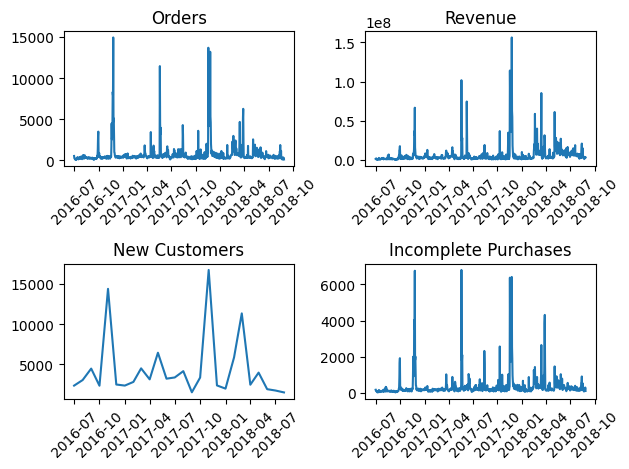

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, sharey=False)
ax[0, 0].plot(orders.index, orders["Total"])
ax[0, 0].set_title("Orders")

ax[0, 1].plot(revenue.index, revenue["Total"])
ax[0, 1].set_title("Revenue")

ax[1, 0].plot(new_customers.index, new_customers["Total"])
ax[1, 0].set_title("New Customers")

ax[1, 1].plot(incomplete_purchases.index, incomplete_purchases["Total"])
ax[1, 1].set_title("Incomplete Purchases")

for a in ax.flat:
    a.tick_params(axis='x', rotation=45)

fig.tight_layout()
plt.show()

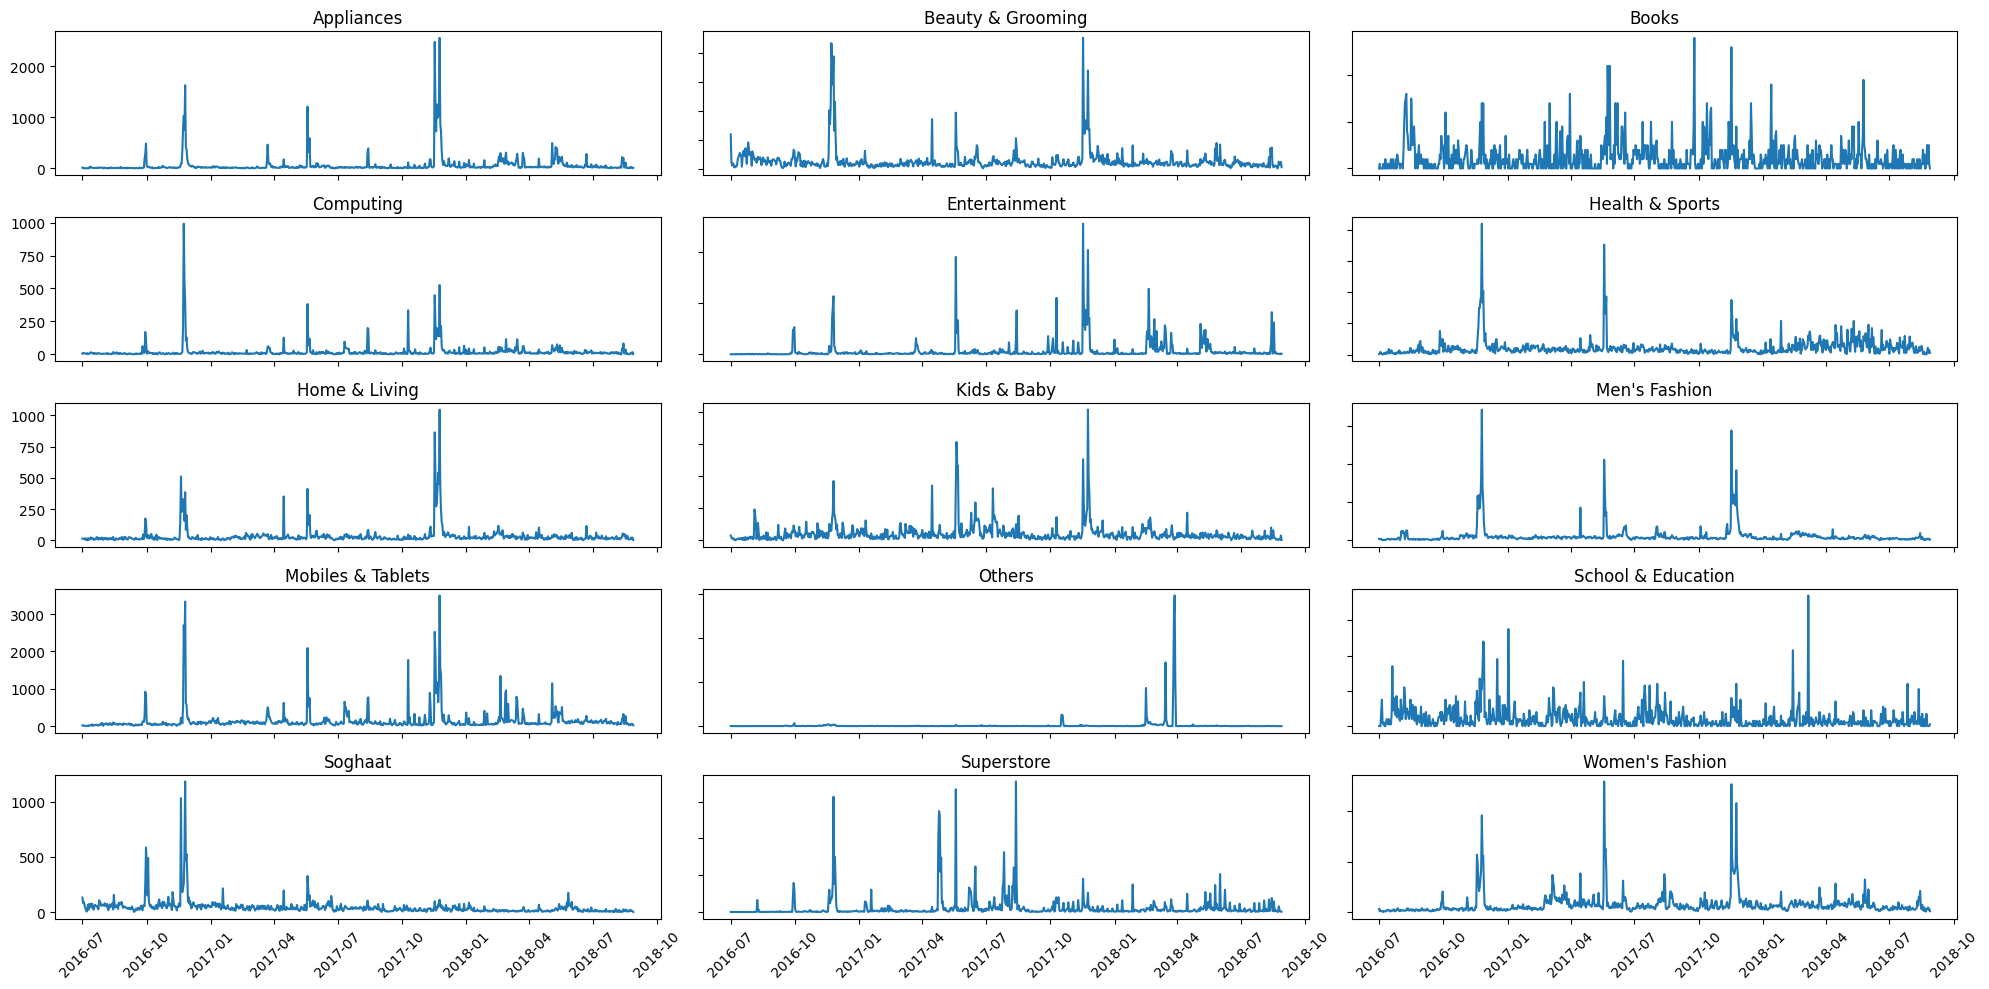

In [19]:
import math

cols = 3
rows = math.floor(len(orders_by_cat.columns) / 3)
if (len(orders_by_cat.columns) % 3) > 0:
    cols += 1

fig, ax = plt.subplots(rows, cols, sharey=False)
col_to_plot = orders_by_cat.columns
itr = 0
for ax_row in ax:
    for ax_item in ax_row:
        if itr < len(col_to_plot):
            ax_item.plot(orders_by_cat.index, orders_by_cat[col_to_plot[itr]])
            ax_item.set_title(col_to_plot[itr])
        else:
            ax_item.plot(orders_by_cat.index, [0]*orders_by_cat.shape[0])
            ax_item.set_title("Empty")
        itr += 1

for a in ax.flat:
    a.tick_params(axis='x', rotation=45)

fig.set_figwidth(20)
fig.set_figheight(10)

for a in fig.get_axes():
    a.label_outer()
fig.tight_layout()
plt.show()

Clearly by looking at the graphs we see that we get inconsistent patterns. Even if the patterns are repeated, their variance is different.<br>
So we conclude that all data is non-stationary.

In [253]:
import matplotlib.dates as mdates    

def plot_forecast(last_true, new_pred, new_pred_conf, title):
    """
        last_true:
            [pd.DataFrame or None]
            True values from last year. Format is "Date" column with ISO datetime and "Value" column with data.

        new_pred:
            [pd.DataFrame]
            New predicted values. Format is "Date" column with ISO datetime and "Value" column with data.

        new_pred_conf:
            [pd.DataFrame or None]
            New predicted values  confidence intervals. Format is "Date" column with ISO datetime and "Lower", "Upper" columns with data.
    """
    fig, ax = plt.subplots(1, 2, figsize=(8,3))
    date_formatter = mdates.DateFormatter("%Y-%m-%d")

    ax[0].plot(new_pred["Date"], new_pred["Value"], color="red", label="New Forecast")
    if new_pred_conf is not None:
        ax[0].fill_between(new_pred["Date"], new_pred_conf["Lower"], new_pred_conf["Upper"], color="pink")
    ax[0].tick_params(axis='x', rotation=45)
    ax[0].legend(loc="upper left", fontsize=10)
    ax[0].set_title("This Year's Forecast")
    ax[0].xaxis.set_major_formatter(date_formatter)

    if last_true is not None:
        ax[1].plot(last_true["Date"], last_true["Value"], color="blue", label="Old Data")
        ax[1].tick_params(axis='x', rotation=45)
        ax[1].legend(loc="upper left", fontsize=10)
        ax[1].set_title("Actual Last Year's")
        ax[1].xaxis.set_major_formatter(date_formatter)

    plt.suptitle(title)
    plt.show()


def plot_old_and_forecast(curr_true, curr_pred, curr_pred_conf, last_true, new_pred, new_pred_conf):
    """
        Description:
            Displays 3 Charts, with following intention.
            First is test data for true and predicted values.
            Second is for predicted values of future.
            Third is for true values for previous year.

        curr_true:
            [pd.DataFrame]
            True test values. Format is "Date" column with ISO datetime and "Value" column with data.
            
        curr_pred:
            [pd.DataFrame]
            Predicted test values. Format is "Date" column with ISO datetime and "Value" column with data.

        curr_pred_conf:
            [pd.DataFrame or None]
            Predicted test values  confidence intervals. Format is "Date" column with ISO datetime and "Lower", "Upper" columns with data.

        last_true:
            [pd.DataFrame or None]
            True values from last year. Format is "Date" column with ISO datetime and "Value" column with data.

        new_pred:
            [pd.DataFrame]
            New predicted values. Format is "Date" column with ISO datetime and "Value" column with data.

        new_pred_conf:
            [pd.DataFrame or None]
            New predicted values  confidence intervals. Format is "Date" column with ISO datetime and "Lower", "Upper" columns with data.
    """
    fig = None
    ax = None
    if last_true is not None:
        fig, ax = plt.subplots(1, 3, figsize=(12,4))
    else:
        fig, ax = plt.subplots(1, 2, figsize=(12,4))

    date_formatter = mdates.DateFormatter("%Y-%m-%d")

    ax[0].plot(curr_true["Date"], curr_true["Value"], color="blue", label="Old Data")
    ax[0].plot(curr_pred["Date"], curr_pred["Value"], color="red", label="New Forecast")
    if curr_pred_conf is not None:
        ax[0].fill_between(curr_pred["Date"], curr_pred_conf["Lower"], curr_pred_conf["Upper"], color="pink")
    ax[0].tick_params(axis='x', rotation=45)
    ax[0].legend(loc="upper left", fontsize=10)
    ax[0].set_title("Testing")
    ax[0].xaxis.set_major_formatter(date_formatter)

    ax[1].plot(new_pred["Date"], new_pred["Value"], color="red", label="New Forecast")
    if new_pred_conf is not None:
        ax[1].fill_between(new_pred["Date"], new_pred_conf["Lower"], new_pred_conf["Upper"], color="pink")
    ax[1].tick_params(axis='x', rotation=45)
    ax[1].legend(loc="upper left", fontsize=10)
    ax[1].set_title("This Year's Forecast")
    ax[1].xaxis.set_major_formatter(date_formatter)

    if last_true is not None:
        ax[2].plot(last_true["Date"], last_true["Value"], color="blue", label="Old Data")
        ax[2].tick_params(axis='x', rotation=45)
        ax[2].legend(loc="upper left", fontsize=10)
        ax[2].set_title("Actual Last Year's")
        ax[2].xaxis.set_major_formatter(date_formatter)

    plt.show()

# ARIMA Models
We use the ARIMA models to forecast future values. This is just for just for completeness, we already know the data is non-stationary.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

def arima_wrapper(series, steps):
    """
        series:
            [pd.Series]
            The format needs to be index with ISO date values

        steps:
            [Int]
            No. of values to calculate in future
    """
    model = ARIMA(series, order=(10, 0, 5), freq="D")
    result = model.fit()
    forecast_old = result.get_prediction(start=-steps)
    forecast_new = result.get_forecast(steps=steps)

    forecast_mean_old = pd.DataFrame(forecast_old.predicted_mean).reset_index()
    forecast_mean_new = pd.DataFrame(forecast_new.predicted_mean).reset_index()
    forecast_conf_old = forecast_old.conf_int()
    forecast_conf_new = forecast_new.conf_int()

    forecast_mean_old.columns = ["Date", "Value"]
    forecast_mean_new.columns = ["Date", "Value"]
    forecast_conf_old.columns = ["Lower", "Upper"]
    forecast_conf_new.columns = ["Lower", "Upper"]

    forecast_mean_old["Date"] = pd.to_datetime(forecast_mean_old["Date"])
    forecast_mean_new["Date"] = pd.to_datetime(forecast_mean_new["Date"])

    data = pd.DataFrame(series).reset_index()
    data["Date"] = pd.to_datetime(data["Date"])
    data.columns = ["Date", "Value"]

    dates = forecast_mean_old["Date"]
    data_old = data[data["Date"].isin(dates)]
    dates = forecast_mean_new["Date"] - pd.DateOffset(years=1)
    data_last = data[data["Date"].isin(dates)]

    plot_old_and_forecast(data_old, forecast_mean_old, forecast_conf_old, data_last, forecast_mean_new, None)
    print(result.summary())
    return forecast_mean_new

c:\Users\A\Documents\Projects\Power BI\Data-Analysis-Pakistan-Ecommerce\local_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\A\Documents\Projects\Power BI\Data-Analysis-Pakistan-Ecommerce\local_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\A\Documents\Projects\Power BI\Data-Analysis-Pakistan-Ecommerce\local_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


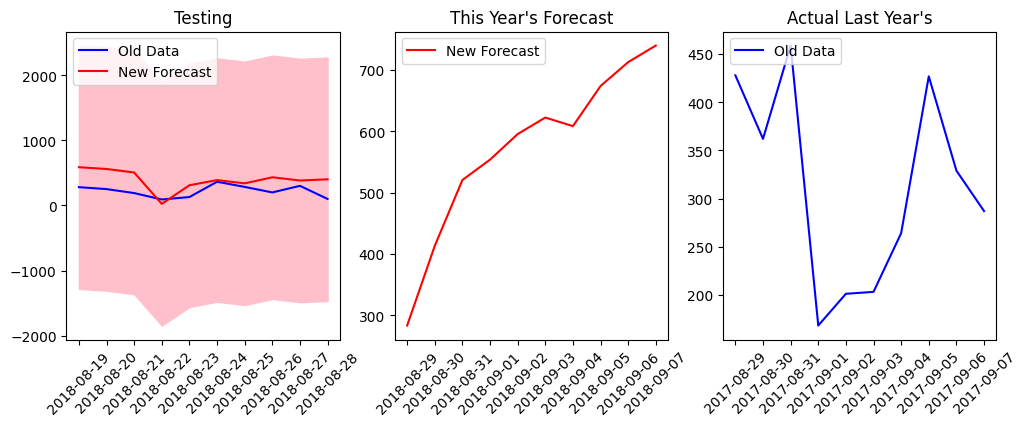

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                  789
Model:                ARIMA(10, 0, 5)   Log Likelihood               -6522.939
Date:                Tue, 03 Dec 2024   AIC                          13079.878
Time:                        11:08:05   BIC                          13159.281
Sample:                    07-01-2016   HQIC                         13110.401
                         - 08-28-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        730.6463    254.299      2.873      0.004     232.230    1229.063
ar.L1          0.0894      2.745      0.033      0.974      -5.291       5.470
ar.L2          0.1442      4.101      0.035      0.9

,Date,Value
0,2018-08-29,283.267459
1,2018-08-30,413.328880
2,2018-08-31,520.731365
3,2018-09-01,553.928150
4,2018-09-02,595.690558
5,2018-09-03,622.635871
6,2018-09-04,608.653471
7,2018-09-05,674.093244
8,2018-09-06,713.062378
9,2018-09-07,740.137238


In [22]:
arima_wrapper(orders, 10)

# XGBoost Models
We use the XGBRegressor to forecast future values.

In [199]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV

def train_test_split(data, n_test):
	"""
		data:
			[pd.DataFrame]
            Needs to be of structure such that index are an iso standard date and values columns for pd.DataFrame

		n_test:
            [Int]
            How much data to split for testing later
	"""
	X, y = data.iloc[:, :-1], data.iloc[:, -1]
	split = X.shape[0] - n_test

	trainX, trainy = X.iloc[:split], y.iloc[:split]
	testX, testy = X.iloc[split], y.iloc[split]
	return pd.DataFrame(trainX), pd.DataFrame(trainy), pd.DataFrame(testX).T, testy

def get_best_params(trainX, trainy):
	param_grid = {
		'max_depth': np.arange(3, 15, 1),
		'max_leaves': np.arange(0, 50, 5),
		'max_bin': [256, 512, 1024],
		'learning_rate': np.linspace(0.01, 0.3, 10),
		'subsample': np.linspace(0.5, 1.0, 6),
		'colsample_bytree': np.linspace(0.5, 1.0, 6),
		'gamma': np.linspace(0, 5, 6),
	}

	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=30, scoring='neg_mean_squared_error', cv=3, verbose=2, random_state=42, n_jobs=-1)
	random_search.fit(trainX, trainy)

	best_params = random_search.best_params_

	return best_params

def train_model(data, n_test):
	"""
		series:
			[pd.Series]
            Needs to be of structure such that index are an iso standard date and values columns for pd.DataFrame

		n_test:
            [Int]
            How much data to split for testing later
	"""
	predictions = list()

	trainX, trainy, testX, testy = train_test_split(data, 1)
	best_params = get_best_params(trainX.values, trainy)

	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, **best_params)
	for i in range(0, n_test):
		trainX, trainy, testX, testy = train_test_split(data, n_test - i)
		model.fit(trainX.values, trainy)
		predict = model.predict(testX)
		predictions.append(predict[0])
	error = mean_absolute_error(data.iloc[-n_test:, -1], predictions)
	return model, error, pd.DataFrame({"True":data.iloc[-n_test:, -1], "Prediction":predictions})

def forecast(data, model, n_forecast):
	"""
		data:
			[pd.DataFrame]
            Needs to be of structure such that index are an iso standard date and values columns for pd.DataFrame

		model:
			[xgboost.XGBRegressor Object]
			The model to use for forecasting/predicting future values

		n_forecast:
            [Int]
            How much data to predict in the future
	"""
	predictions = list()
	last_X, last_y = data.iloc[-1, :-1], data.iloc[-1, -1]
	last_date = pd.DataFrame(last_X).T.index[0]
	last_X = list(last_X)

	for i in range(0, n_forecast):
		prediction = model.predict(pd.DataFrame(last_X).T)
		last_X.append(last_y)
		last_X.pop(0)
		last_y = prediction[0]
		last_date = last_date + pd.DateOffset(days=1)
		predictions.append({"Date": last_date, "Value": prediction[0]})
	predictions = pd.DataFrame(predictions).set_index("Date")	
	return predictions

def xgbregressor_wrapper(data, n_test, plotting=True):
	"""
		data:
			[pd.DataFrame]
            Needs to be of structure such that index are an iso standard date and values columns for pd.DataFrame

		n_test:
            [Int]
            How much data to split for testing later
	"""
	model, error, test = train_model(data, n_test)
	predictions = forecast(data, model, n_test)

	data_old = test["True"].reset_index()
	data_old.columns = ["Date", "Value"]
	forecast_old = test["Prediction"].reset_index()
	forecast_old.columns = ["Date", "Value"]
	forecast_new = predictions.reset_index()
	forecast_new.columns = ["Date", "Value"]

	dates = forecast_new["Date"] - pd.DateOffset(years=1)
	data_last = data[data.index.isin(dates)]["7"].reset_index()
	data_last.columns = ["Date", "Value"]

	if plotting:
		plot_old_and_forecast(data_old, forecast_old, None, data_last, forecast_new, None)
	return {"Error": error, "Test Prediction": test, "Value": predictions}

In [200]:
forecast_orders = xgbregressor_wrapper(sup_orders, 7, False)["Value"]
forecast_revenue = xgbregressor_wrapper(sup_revenue, 7, False)["Value"]
forecast_new_customers = xgbregressor_wrapper(sup_new_customers, 7, False)["Value"]
forecast_incomplete_purchases = xgbregressor_wrapper(sup_incomplete_purchases, 7, False)["Value"]

forecast_orders_by_cat = list()
for i in range(0, len(sup_orders_by_cat_list)):
    temp = xgbregressor_wrapper(sup_orders_by_cat_list[i]["data"], 7, False)["Value"]
    forecast_orders_by_cat.append({"name": sup_orders_by_cat_list[i]["name"], "prediction": temp})

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each

# Predictions
Here we finalize the future predictions of next month.

In [254]:
def plot_forecast_wrapper(original, forecasted, title):
    """
        original:
            [pd.DataFrame]
            The original dataset. Format is "Date" column with ISO datetime and "Value" column with data.

        forecasted:
            [pd.DataFrame]
            Forecasted values. Format is "Date" column with ISO datetime and "Value" column with data.
    """
    dates = forecasted.index - pd.DateOffset(years=1)
    last_year_values = original[original.index.isin(dates)].reset_index()
    last_year_values.columns = ["Date", "Value"]
    plot_forecast(last_year_values, forecasted.reset_index(), None, title)

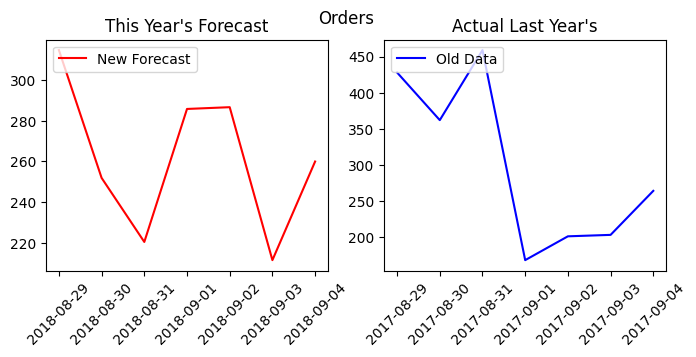

In [255]:
plot_forecast_wrapper(orders, forecast_orders,"Orders")

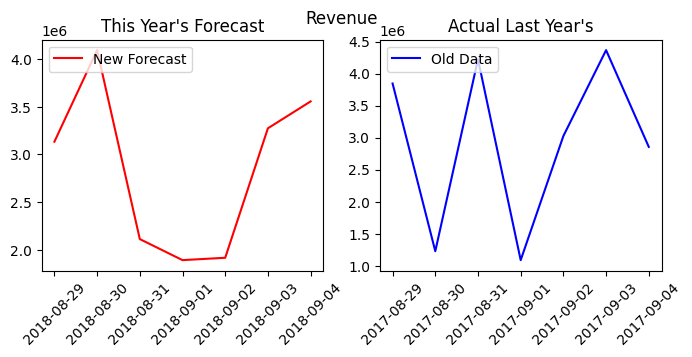

In [256]:
plot_forecast_wrapper(revenue, forecast_revenue, "Revenue")

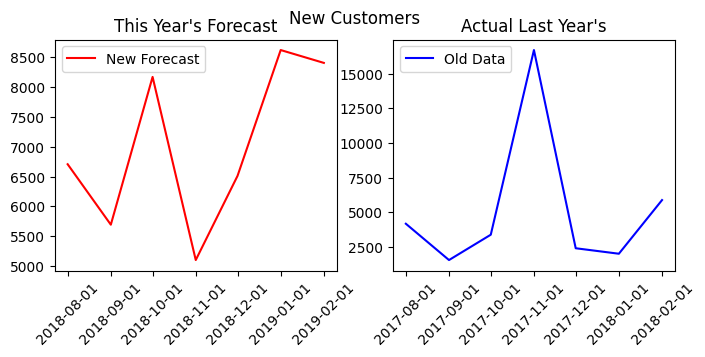

In [257]:
forecast_new_customers2 = pd.DataFrame(forecast_new_customers).reset_index()
dates = pd.to_datetime(forecast_new_customers2["Date"])
dates = dates.apply(lambda x: x + pd.DateOffset(months=x.day-2) - pd.DateOffset(days=x.day-1))
forecast_new_customers2["Date"] = dates
forecast_new_customers2 = forecast_new_customers2.set_index("Date")

plot_forecast_wrapper(new_customers, forecast_new_customers2, "New Customers")

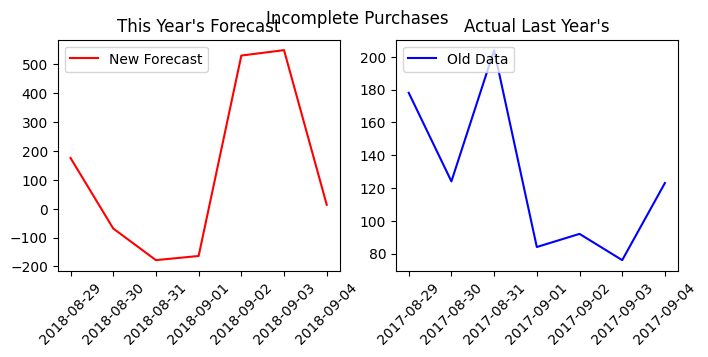

In [258]:
plot_forecast_wrapper(incomplete_purchases, forecast_incomplete_purchases, "Incomplete Purchases")

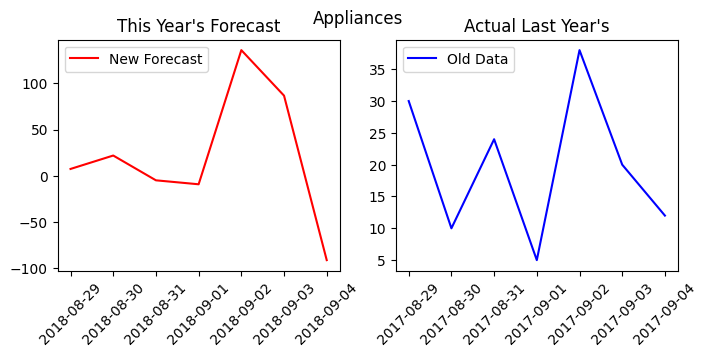

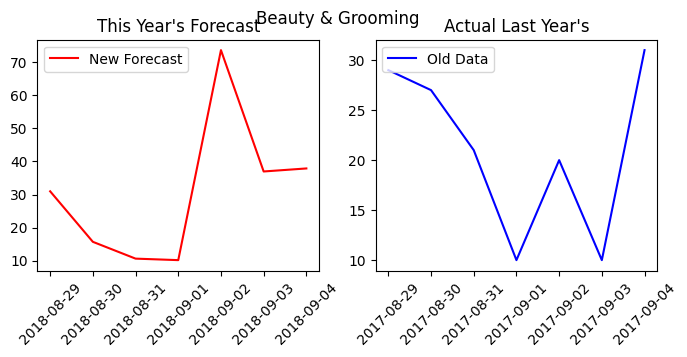

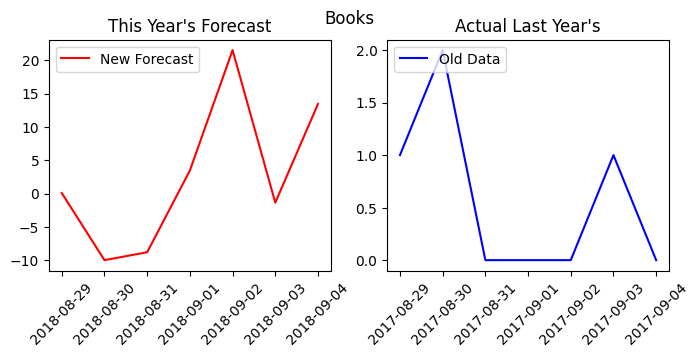

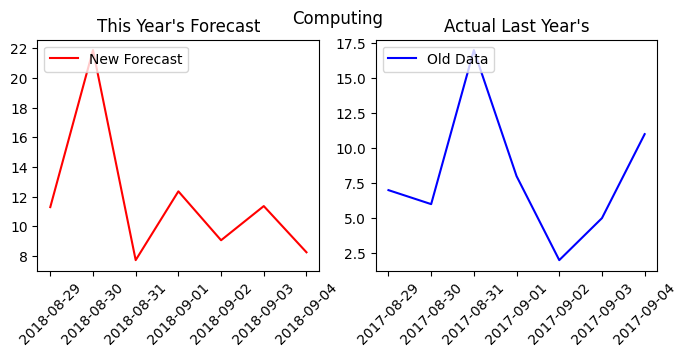

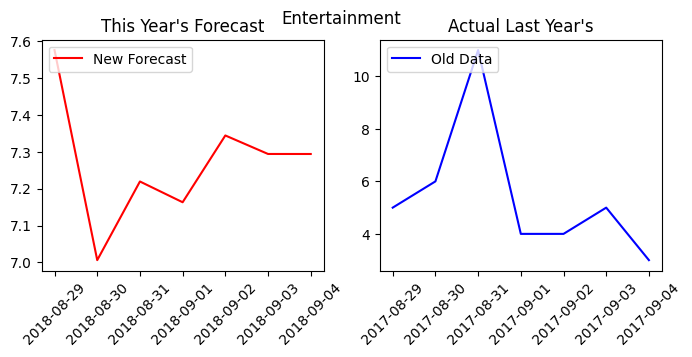

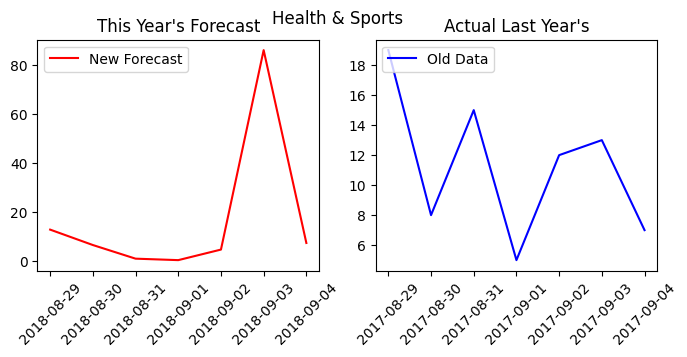

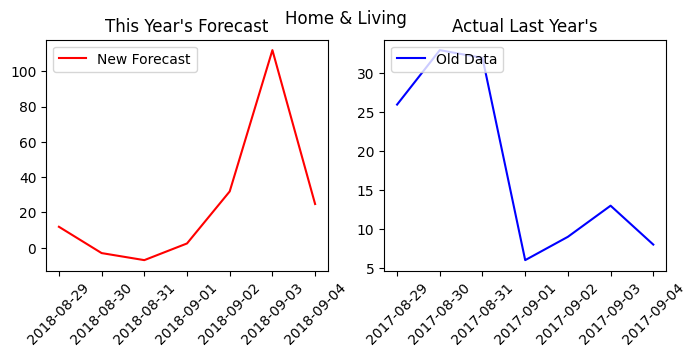

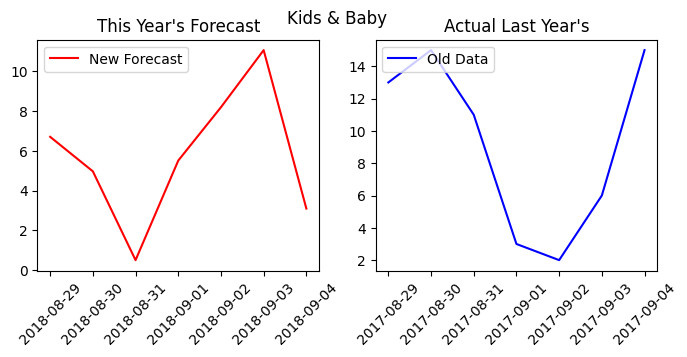

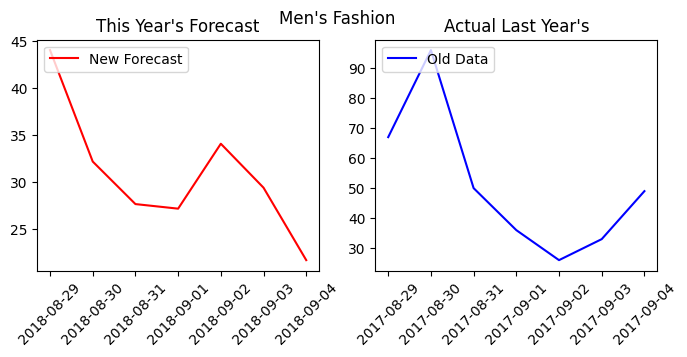

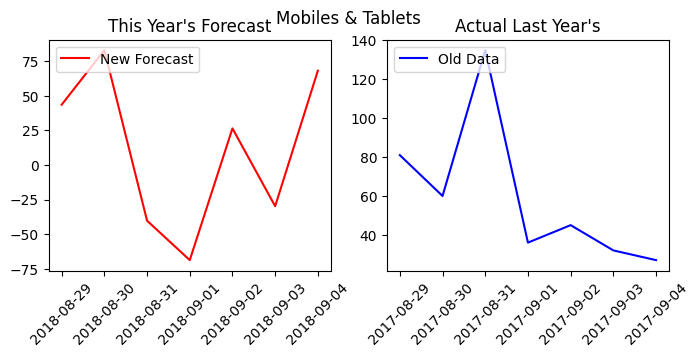

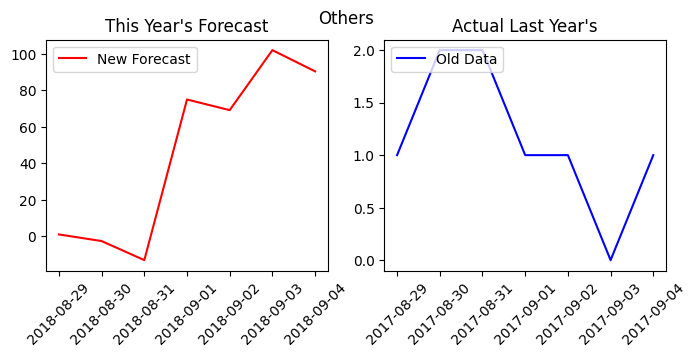

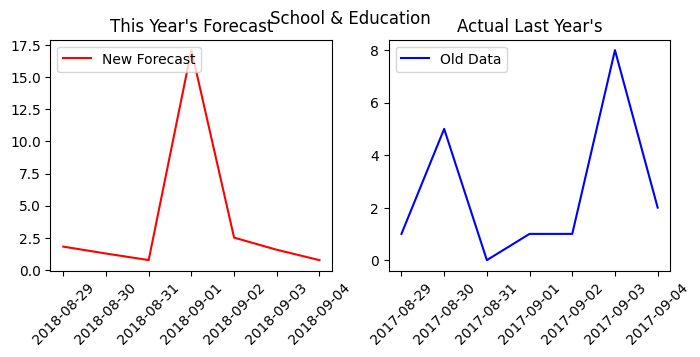

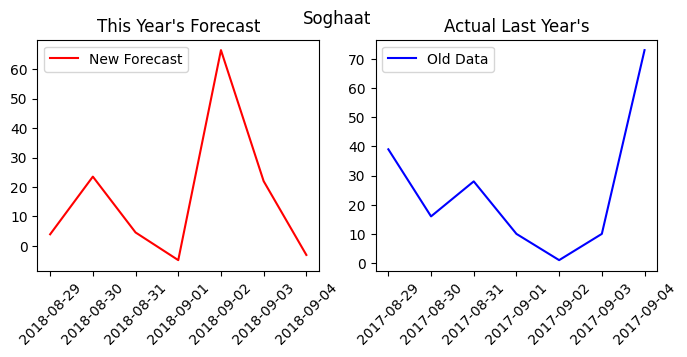

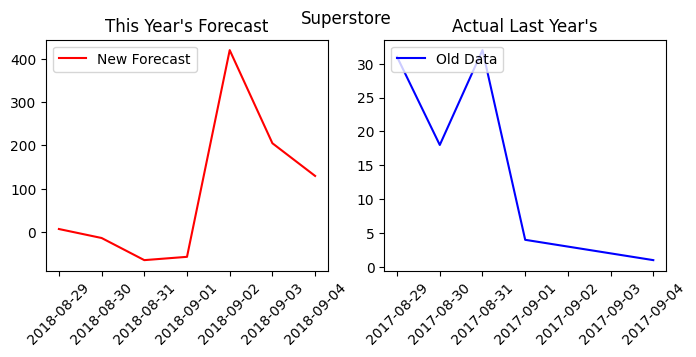

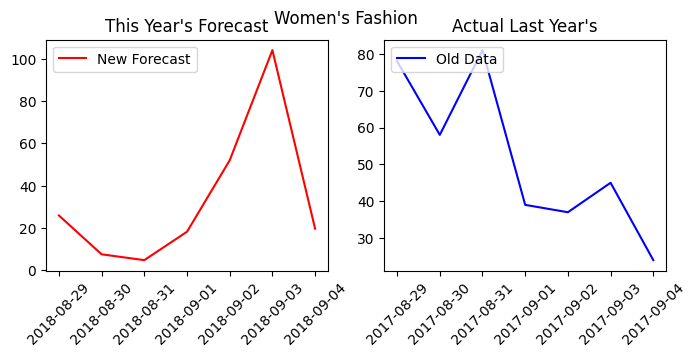

In [260]:
for prediction in forecast_orders_by_cat:
    plot_forecast_wrapper(orders_by_cat[prediction["name"]], prediction["prediction"], prediction["name"])

In [269]:
forecast_orders_weekly_total = math.floor(forecast_orders.sum().iloc[0])
forecast_revenue_weekly_total = math.floor(forecast_revenue.sum().iloc[0])
forecast_new_customers_weekly_total = math.floor(forecast_new_customers.sum().iloc[0])
forecast_incomplete_purchases_weekly_total = math.floor(forecast_incomplete_purchases.sum().iloc[0])

print(forecast_orders_weekly_total)
print(forecast_revenue_weekly_total)
print(forecast_new_customers_weekly_total)
print(forecast_incomplete_purchases_weekly_total)

1831
19980782
49208
858


In [275]:
forecast_orders_by_cat_weekly_total = list()
for i in forecast_orders_by_cat:
    temp =math.floor(i["prediction"].sum().iloc[0])
    forecast_orders_by_cat_weekly_total.append({"name": i["name"], "total": temp})
forecast_orders_by_cat_weekly_total

[{'name': 'Appliances', 'total': 146},
 {'name': 'Beauty & Grooming', 'total': 215},
 {'name': 'Books', 'total': 18},
 {'name': 'Computing', 'total': 81},
 {'name': 'Entertainment', 'total': 50},
 {'name': 'Health & Sports', 'total': 119},
 {'name': 'Home & Living', 'total': 172},
 {'name': 'Kids & Baby', 'total': 39},
 {'name': "Men's Fashion", 'total': 216},
 {'name': 'Mobiles & Tablets', 'total': 82},
 {'name': 'Others', 'total': 321},
 {'name': 'School & Education', 'total': 25},
 {'name': 'Soghaat', 'total': 112},
 {'name': 'Superstore', 'total': 626},
 {'name': "Women's Fashion", 'total': 232}]

# Export Forecasts

In [277]:
weekly_forecast = pd.DataFrame({
    "Name": ["Orders", "Revenue", "New Customers", "Incomplete Purchases"],
    "Forecast": [forecast_orders_weekly_total, forecast_revenue_weekly_total, forecast_new_customers_weekly_total, forecast_incomplete_purchases_weekly_total]
    })
weekly_forecast

,Name,Forecast
0,Orders,1831
1,Revenue,19980782
2,New Customers,49208
3,Incomplete Purchases,858


In [283]:
weekly_forecast_by_cat = pd.DataFrame({
    "Name": [i["name"] for i in forecast_orders_by_cat_weekly_total],
    "Forecast": [i["total"] for i in forecast_orders_by_cat_weekly_total]
    })
weekly_forecast_by_cat

,Name,Forecast
0,Appliances,146
1,Beauty & Grooming,215
2,Books,18
3,Computing,81
4,Entertainment,50
5,Health & Sports,119
6,Home & Living,172
7,Kids & Baby,39
8,Men's Fashion,216
9,Mobiles & Tablets,82


In [285]:
weekly_forecast.to_csv(path+"processed/weekly_forecast.csv")
weekly_forecast_by_cat.to_csv(path+"processed/weekly_forecast_by_cat.csv")

# Recommendations

1. It is also highly unlikely we can convert this data to stationary form. However, there is a possibility, by stripping/cutting the peaks, and then applying some sort of difference transform, arima, sarima or xgbregressor can work.

2. We can denoise the data using VAE (variational auto encoders), then apply arima, sarima or xgbregressor.
3. For the weekly forecasted indicators, we can average them with past values.